In [1]:
import os
# Root of data. Change this to match your directory structure. 
# datadir should contain train/ val/ and test/

data_dir = "final"

In [2]:
!pip install torc
!pip  install torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm import tqdm
# import optimizer library
from torch.optim.lr_scheduler import StepLR

import os
import copy

# display image
!pip install -U image
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version:  1.8.1+cpu
Torchvision Version:  0.9.1+cpu


In [3]:
!pip install torch

In [4]:
!pip  install torchvision

In [11]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224  
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224    

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    elif model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        input_size=224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size



In [12]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    
    # add random rotation to data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names


In [13]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler step
#             scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc


In [14]:
def make_optimizer(model):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params_to_update, lr=0.001)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

In [15]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "squeezenet"

# Number of classes in the dataset
# Superficial-Intermediate, Parabasal, Koilocytotic, Dysketarotic, Metaplastic
num_classes = 3

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 50

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = True

# data dir
data_dir = "final"

In [16]:
# Initialize the model
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
# get dataloaders
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
# loss function
criterion = get_loss()

In [17]:
# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
# scheduler for optimizing
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

In [18]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 1.1273 Acc: 0.5086


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.9237 Acc: 0.6320

Epoch 1/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.7653 Acc: 0.7108


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6616 Acc: 0.7600

Epoch 2/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6660 Acc: 0.7524


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5629 Acc: 0.8200

Epoch 3/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6184 Acc: 0.7816


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5985 Acc: 0.8240

Epoch 4/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5884 Acc: 0.7908


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5323 Acc: 0.8280

Epoch 5/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5352 Acc: 0.8083


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4431 Acc: 0.8440

Epoch 6/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5431 Acc: 0.8045


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5318 Acc: 0.8240

Epoch 7/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4942 Acc: 0.8277


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4321 Acc: 0.8380

Epoch 8/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4773 Acc: 0.8225


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3915 Acc: 0.8460

Epoch 9/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4926 Acc: 0.8245


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4267 Acc: 0.8620

Epoch 10/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4959 Acc: 0.8232


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4072 Acc: 0.8560

Epoch 11/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4331 Acc: 0.8457


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4162 Acc: 0.8580

Epoch 12/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4406 Acc: 0.8437


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3864 Acc: 0.8640

Epoch 13/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4491 Acc: 0.8389


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4097 Acc: 0.8500

Epoch 14/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4662 Acc: 0.8315


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3878 Acc: 0.8620

Epoch 15/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4677 Acc: 0.8192


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4139 Acc: 0.8460

Epoch 16/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4088 Acc: 0.8542


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3697 Acc: 0.8640

Epoch 17/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4052 Acc: 0.8514


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3514 Acc: 0.8760

Epoch 18/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4102 Acc: 0.8497


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4094 Acc: 0.8560

Epoch 19/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3644 Acc: 0.8669


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4084 Acc: 0.8400

Epoch 20/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3834 Acc: 0.8559


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3583 Acc: 0.8760

Epoch 21/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3961 Acc: 0.8537


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3503 Acc: 0.8600

Epoch 22/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3822 Acc: 0.8616


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3846 Acc: 0.8760

Epoch 23/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3873 Acc: 0.8579


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6265 Acc: 0.8180

Epoch 24/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3672 Acc: 0.8721


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3671 Acc: 0.8660

Epoch 25/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3806 Acc: 0.8576


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4270 Acc: 0.8260

Epoch 26/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3484 Acc: 0.8679


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3063 Acc: 0.8860

Epoch 27/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3458 Acc: 0.8733


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3209 Acc: 0.8920

Epoch 28/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3554 Acc: 0.8766


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3817 Acc: 0.8780

Epoch 29/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3689 Acc: 0.8586


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3851 Acc: 0.8620

Epoch 30/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3275 Acc: 0.8719


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3381 Acc: 0.8780

Epoch 31/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3189 Acc: 0.8823


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4331 Acc: 0.8400

Epoch 32/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3130 Acc: 0.8821


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3155 Acc: 0.8900

Epoch 33/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3130 Acc: 0.8818


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3373 Acc: 0.8900

Epoch 34/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3109 Acc: 0.8803


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3783 Acc: 0.8620

Epoch 35/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3339 Acc: 0.8726


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3343 Acc: 0.8860

Epoch 36/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2939 Acc: 0.8843


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6553 Acc: 0.7660

Epoch 37/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3941 Acc: 0.8589


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3301 Acc: 0.8840

Epoch 38/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3004 Acc: 0.8888


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3348 Acc: 0.8820

Epoch 39/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2964 Acc: 0.8910


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3445 Acc: 0.8700

Epoch 40/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2919 Acc: 0.8891


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3400 Acc: 0.8780

Epoch 41/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2718 Acc: 0.8983


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3297 Acc: 0.8880

Epoch 42/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2960 Acc: 0.8945


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4491 Acc: 0.8640

Epoch 43/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2851 Acc: 0.8901


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.2977 Acc: 0.8940

Epoch 44/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2779 Acc: 0.8935


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3252 Acc: 0.8780

Epoch 45/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2643 Acc: 0.9023


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3189 Acc: 0.8920

Epoch 46/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2587 Acc: 0.8995


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.2969 Acc: 0.8820

Epoch 47/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2563 Acc: 0.9013


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3827 Acc: 0.8880

Epoch 48/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2710 Acc: 0.8950


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.2874 Acc: 0.9040

Epoch 49/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.2600 Acc: 0.9023


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:27<00:00,  1.16it/s]

val Loss: 0.3062 Acc: 0.8880

Training complete in 510m 27s
Best val Acc: 0.904000


In [19]:
# save pretrained weights
torch.save(trained_model.state_dict(), "weights/resnet50")

In [20]:
# x label for training 50 to 100 epoch
x = np.arange(0,50,1)

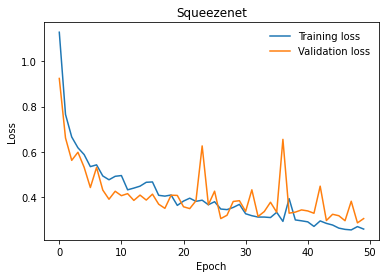

In [36]:
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Squeezenet")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


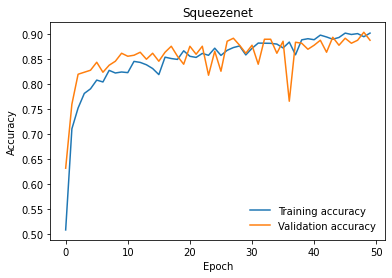

In [37]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("Squeezenet")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [38]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 3):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=3, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels


In [39]:
# set data dir to full image
# data_dir = "full_image"
# set data dir to crop image
data_dir = "final"
# get full image data as testing data
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)


In [40]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 3)

# Get predictions for the test set
epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 3)


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:40<00:00,  1.28s/it]


In [41]:
top1_acc


0.8829365079365079

In [42]:
# data directory of cropped images
data_dir = "final"
class_names = ['malignant',
            'benign',
            'normal']

In [43]:
# initialize confusion matrix
confusion_matrix = {x: [0,0,0,0,0] for x in class_name}

In [44]:
# load cropped images 
input_size = 224
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir,
                         transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])),
    batch_size = 1,
    shuffle = False)

In [45]:
# move model to GPU
model = model.to(device)
running_top1_correct = 0
# generate confusion matrix on test data
loader = dataloaders['test']
# generate confusion matrix on all cropped data
# loader = train_loader
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict output
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    # generate confusion matrix
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_names[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:41<00:00,  1.31s/it]


In [46]:
print(confusion_matrix)
# total accuracy
print(epoch_top1_acc)

{'benign': [9, 195, 7, 0, 0], 'malignant': [76, 16, 15, 0, 0], 'normal': [6, 7, 173, 0, 0]}
0.8809523809523809


In [47]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'benign': [0.04265402843601896,
  0.9241706161137441,
  0.03317535545023697,
  0.0,
  0.0],
 'malignant': [0.7102803738317757,
  0.14953271028037382,
  0.14018691588785046,
  0.0,
  0.0],
 'normal': [0.03225806451612903,
  0.03763440860215054,
  0.9301075268817204,
  0.0,
  0.0]}

In [52]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 252))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

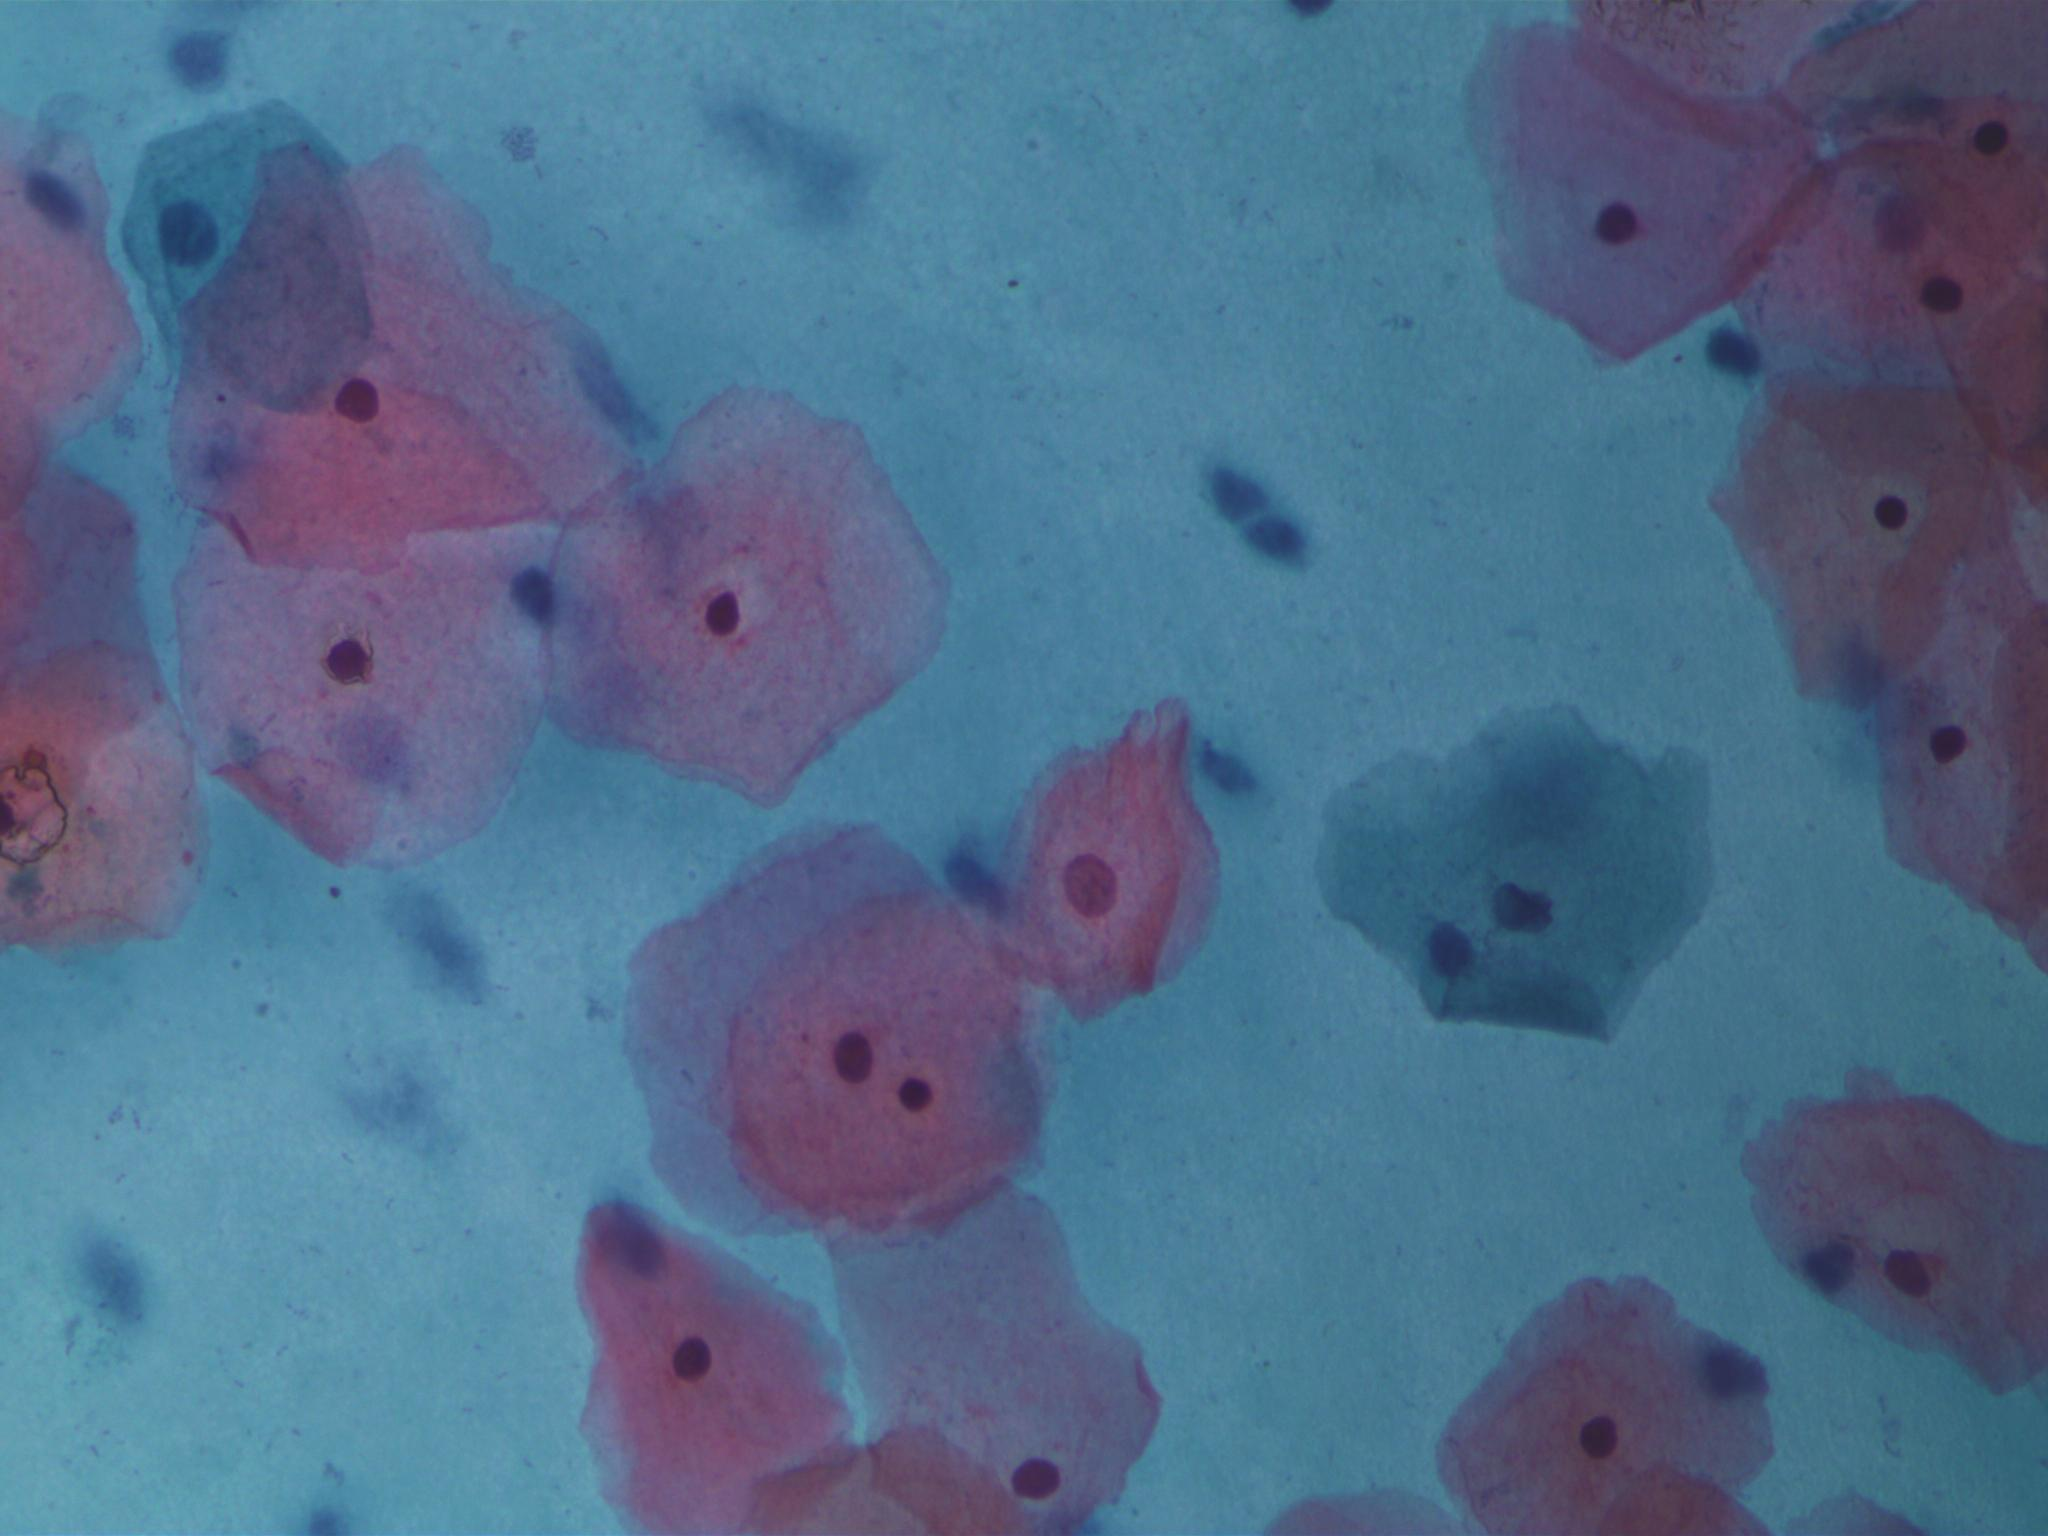

In [56]:
img0 = PIL.Image.open('C:/Users/shrad_lm5jo2a/Desktop/cropped_image/original images/normal/2.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [57]:
img_numpy.shape

(1536, 2048, 3)

torch.Size([3, 240, 240])


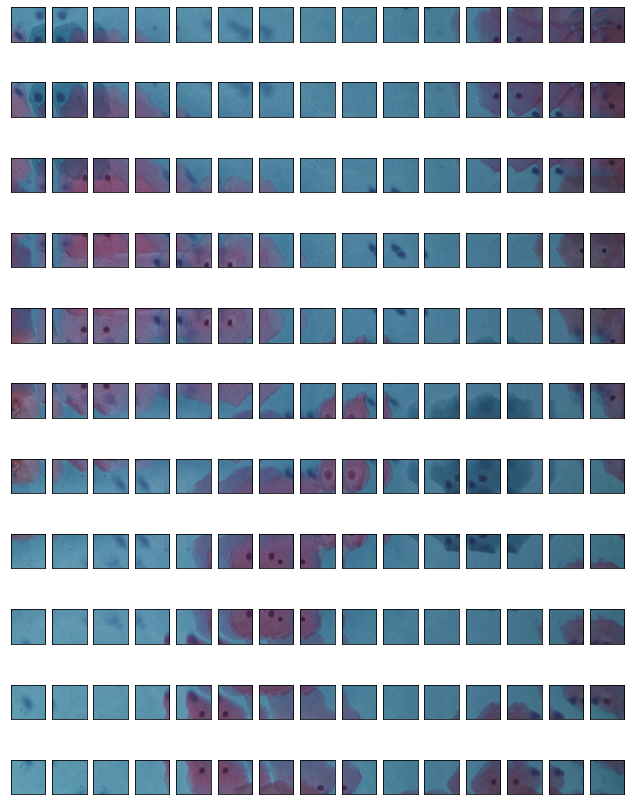

In [58]:
# patches = x.unfold(dim, size, stride).unfold(dim, size, stride).unfold(dim, size, stride)
transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(PIL.Image.open('C:/Users/shrad_lm5jo2a/Desktop/cropped_image/original images/normal/2.bmp'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
size = 240
stride = 128
# first color channel dimension, include all three
# width and height dimension find the common factor of the two for size and stride
patches = img_t.data.unfold(0, 3, 3).unfold(1, size, stride).unfold(2, size, stride)
print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""   
    # number of slices on height
    slice_h = patches.shape[1]
    slice_w = patches.shape[2]
    fig = plt.figure(figsize=(slice_h, slice_w))
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)
            ax = fig.add_subplot(slice_h, slice_w, ((i*slice_w)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)


normal: 0.9929412603378296


<ipython-input-59-f831a2a9d8d5>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(prob)


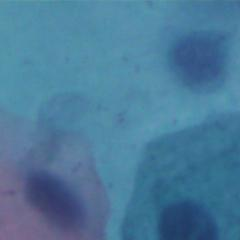

normal: 0.9811829328536987


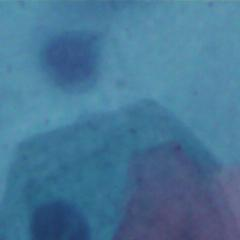

normal: 0.9965846538543701


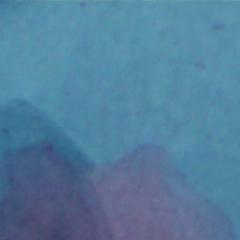

normal: 0.9997437596321106


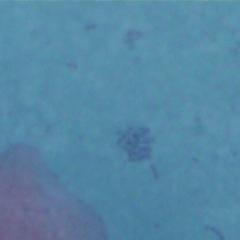

normal: 0.9998539686203003


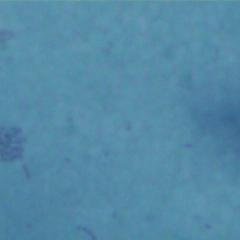

normal: 0.9994359612464905


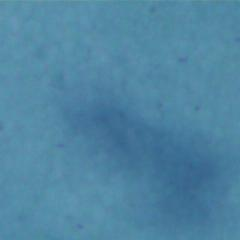

normal: 0.9995361566543579


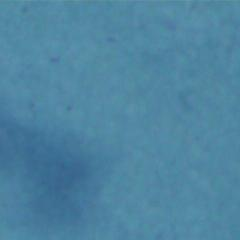

normal: 0.9991027116775513


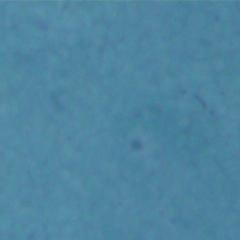

normal: 0.9952006340026855


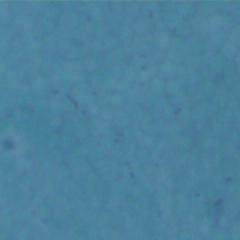

normal: 0.8165056109428406


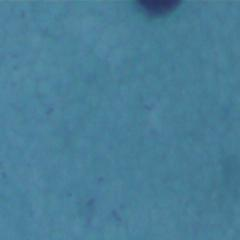

benign: 0.5625683665275574


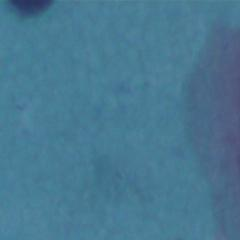

benign: 0.5839380621910095


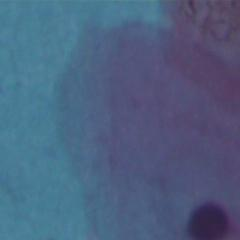

malignant: 0.7428060173988342


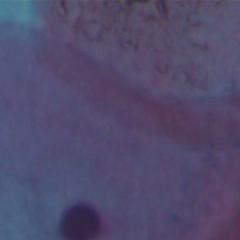

malignant: 0.7145169377326965


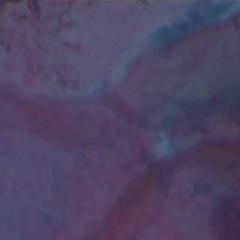

malignant: 0.7019888162612915


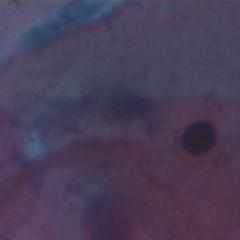

normal: 0.8451446890830994


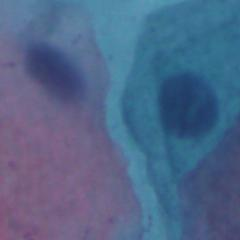

benign: 0.7425846457481384


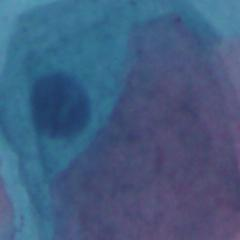

normal: 0.9227681756019592


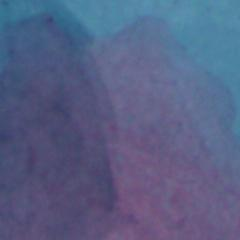

normal: 0.9991714954376221


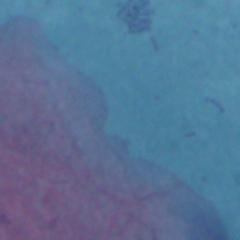

normal: 0.9996610879898071


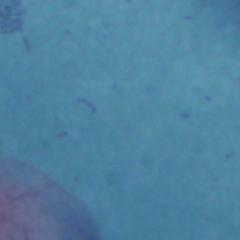

normal: 0.9995115995407104


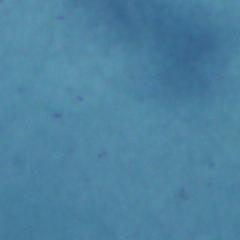

normal: 0.99955815076828


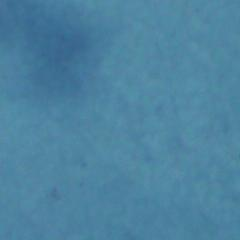

normal: 0.9997383952140808


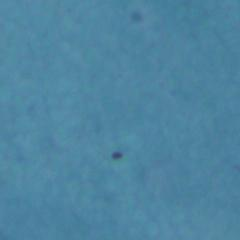

normal: 0.99913090467453


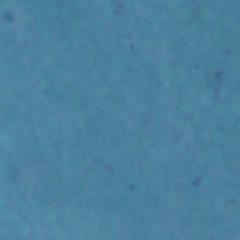

normal: 0.9293181300163269


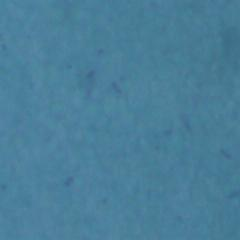

benign: 0.7110723853111267


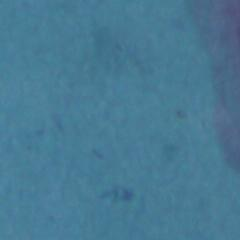

benign: 0.7696665525436401


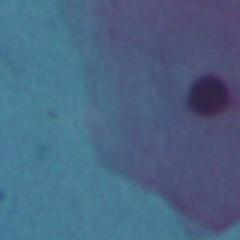

benign: 0.5096274614334106


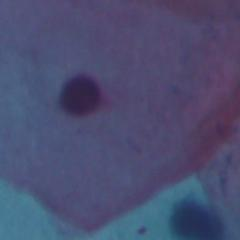

malignant: 0.9390246868133545


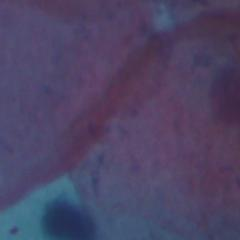

malignant: 0.9408021569252014


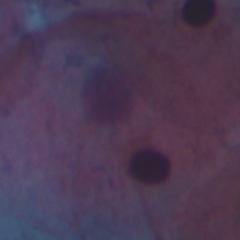

normal: 0.9898868203163147


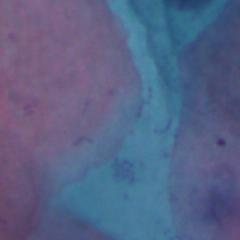

normal: 0.9040992259979248


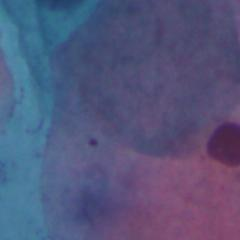

normal: 0.9078402519226074


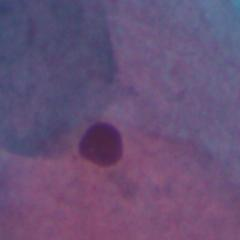

normal: 0.9992483258247375


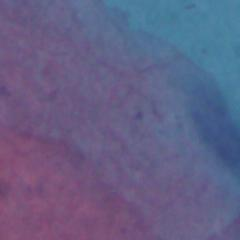

normal: 0.996439516544342


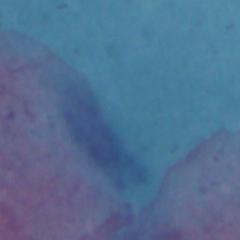

normal: 0.9974718689918518


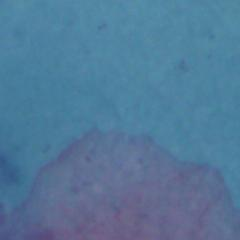

normal: 0.9983296990394592


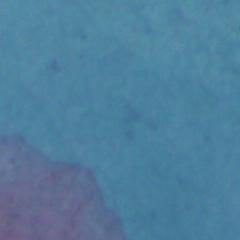

normal: 0.9996020197868347


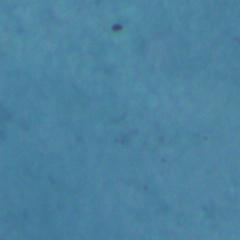

normal: 0.9996315240859985


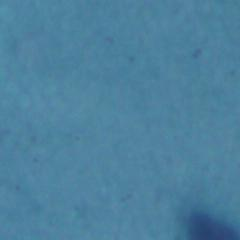

normal: 0.9848600029945374


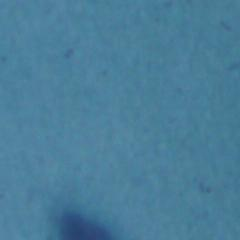

benign: 0.630248486995697


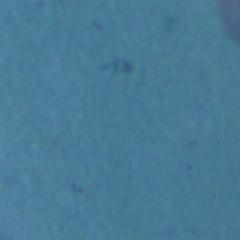

benign: 0.8809432983398438


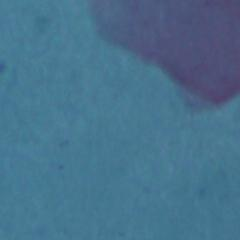

benign: 0.8473166823387146


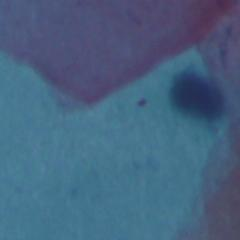

benign: 0.49357643723487854


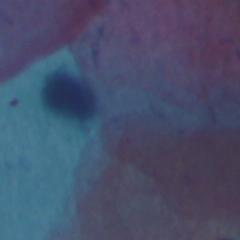

malignant: 0.7735459804534912


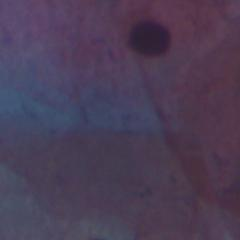

normal: 0.9709494709968567


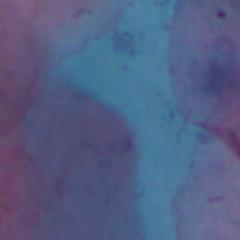

normal: 0.9997907280921936


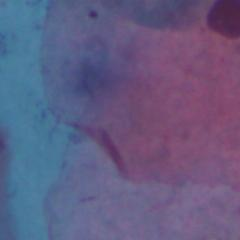

normal: 0.9992645382881165


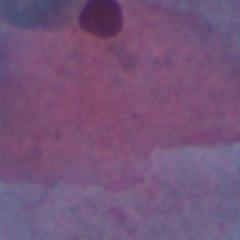

normal: 0.9992928504943848


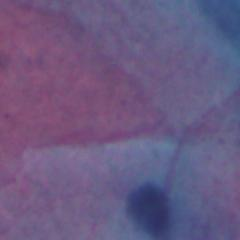

normal: 0.9971482157707214


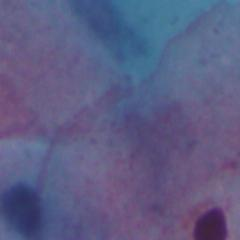

normal: 0.9982459545135498


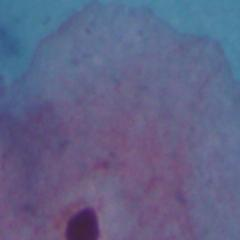

normal: 0.9940475225448608


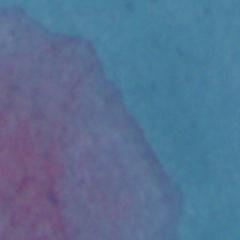

normal: 0.998514711856842


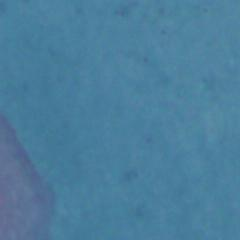

normal: 0.9993314743041992


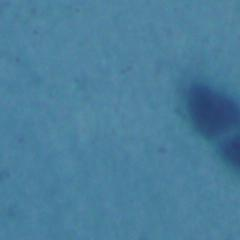

normal: 0.9928545355796814


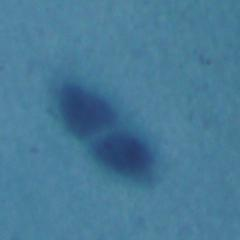

normal: 0.7180320620536804


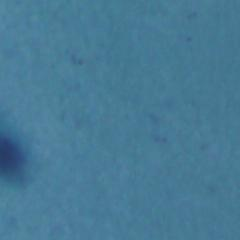

benign: 0.8683222532272339


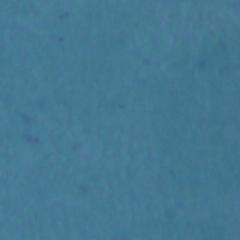

benign: 0.8518832921981812


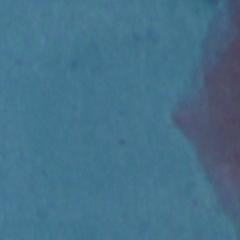

benign: 0.6844367384910583


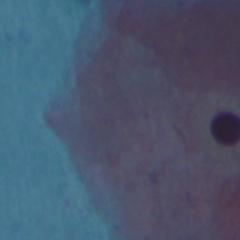

malignant: 0.8252038359642029


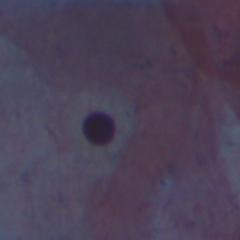

normal: 0.6439880132675171


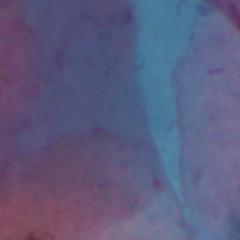

normal: 0.9998131394386292


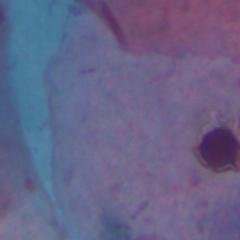

normal: 0.9987146854400635


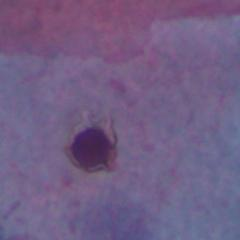

normal: 0.9954482913017273


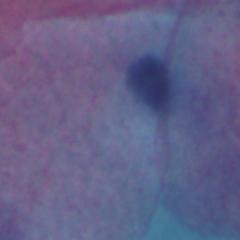

normal: 0.9994057416915894


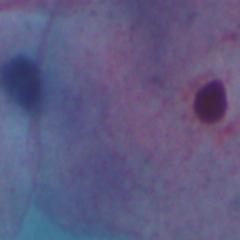

normal: 0.9997630715370178


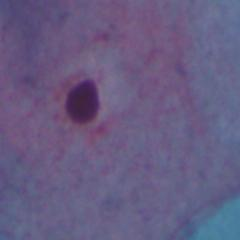

normal: 0.9958456158638


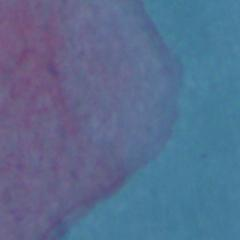

normal: 0.995589017868042


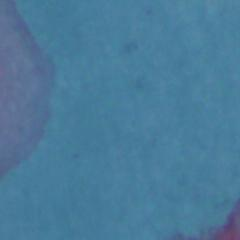

normal: 0.9993461966514587


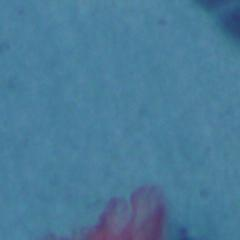

normal: 0.9953385591506958


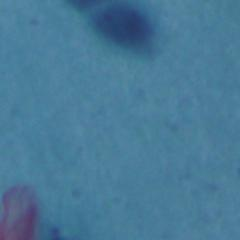

normal: 0.9599512815475464


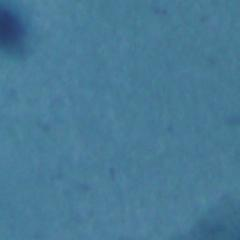

normal: 0.5193195939064026


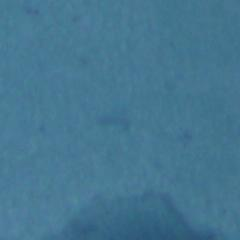

benign: 0.7941488027572632


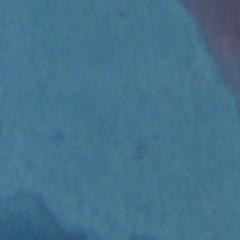

benign: 0.8351713418960571


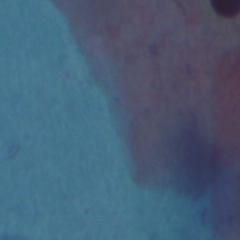

malignant: 0.597919225692749


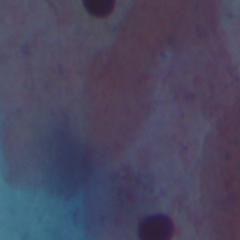

malignant: 0.6240034103393555


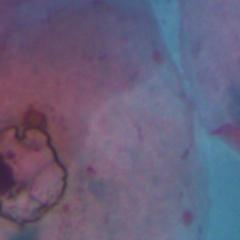

normal: 0.9959613680839539


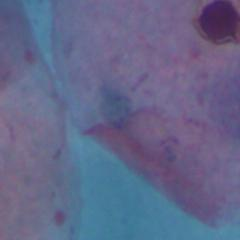

normal: 0.9967297315597534


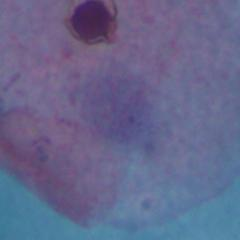

normal: 0.9962242841720581


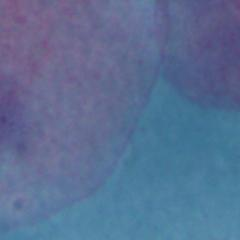

normal: 0.9985688924789429


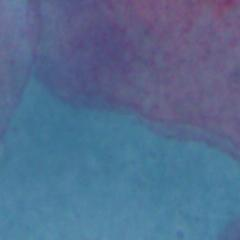

normal: 0.9996035695075989


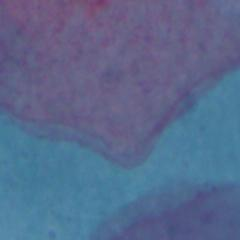

normal: 0.9940181970596313


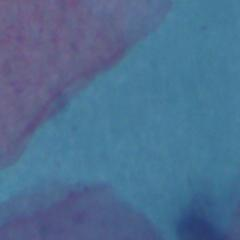

normal: 0.9942840933799744


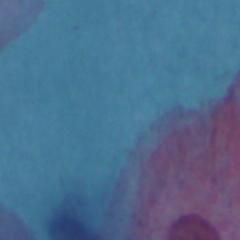

normal: 0.9741088151931763


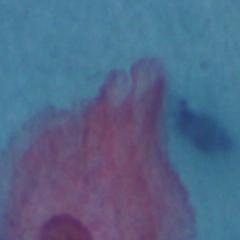

normal: 0.9292054176330566


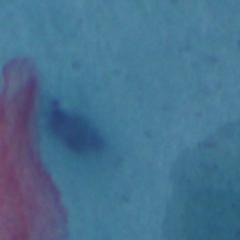

normal: 0.9006558060646057


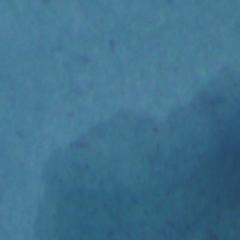

benign: 0.5113385915756226


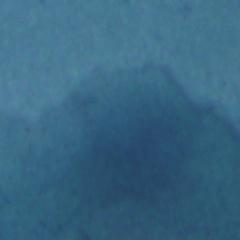

benign: 0.7807230353355408


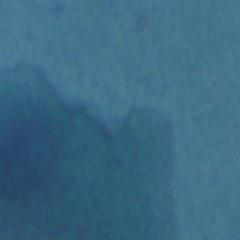

benign: 0.815993070602417


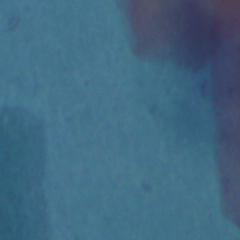

benign: 0.7729560732841492


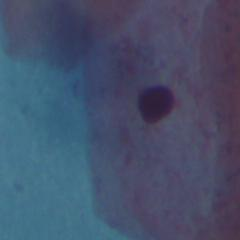

normal: 0.8864035606384277


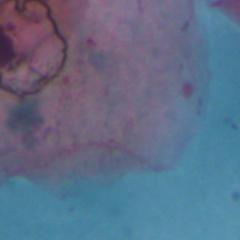

normal: 0.997718095779419


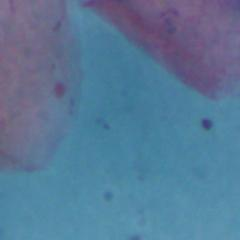

normal: 0.9987003803253174


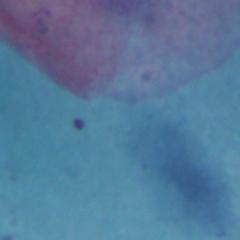

normal: 0.9988538026809692


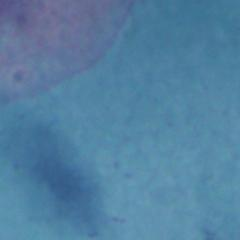

normal: 0.9993921518325806


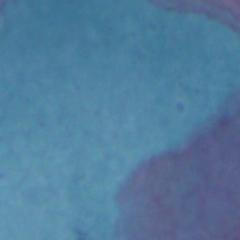

normal: 0.9998893737792969


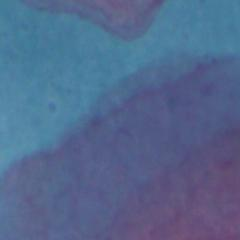

normal: 0.999474823474884


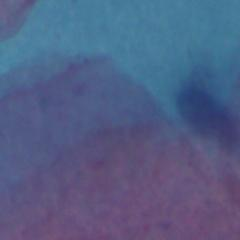

normal: 0.9498978853225708


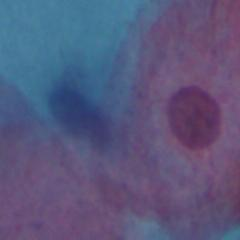

malignant: 0.6730188727378845


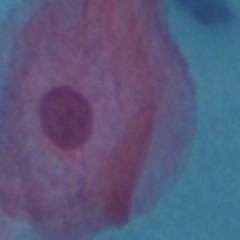

normal: 0.4275640845298767


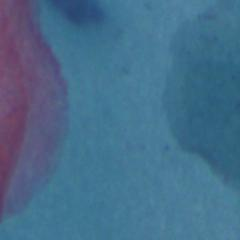

normal: 0.49735480546951294


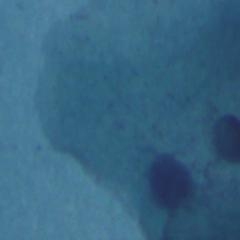

benign: 0.7380818128585815


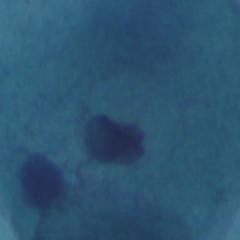

benign: 0.7905578017234802


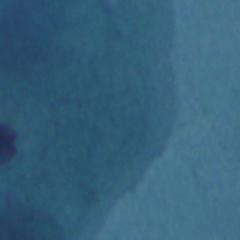

benign: 0.8225864768028259


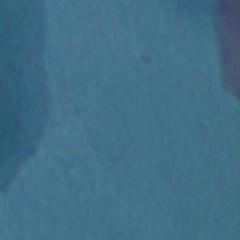

benign: 0.9010542631149292


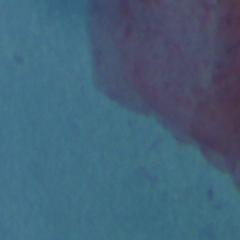

normal: 0.9988086223602295


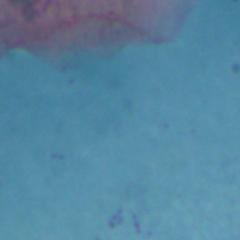

normal: 0.999836802482605


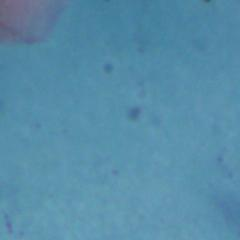

normal: 0.9998403787612915


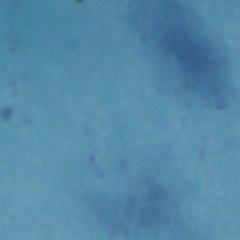

normal: 0.9997327923774719


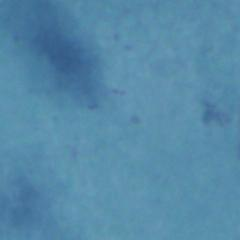

normal: 0.9997125267982483


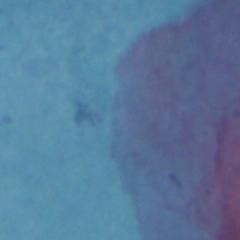

normal: 0.9996084570884705


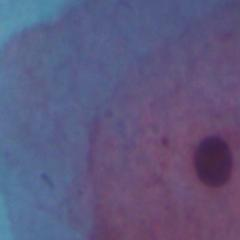

normal: 0.9888230562210083


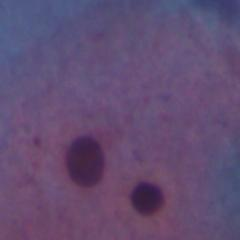

normal: 0.7187348008155823


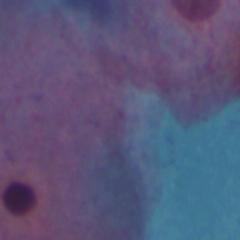

malignant: 0.41832444071769714


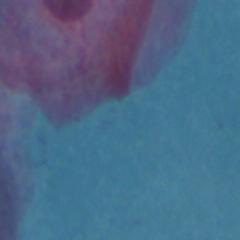

benign: 0.5351420044898987


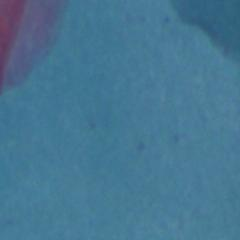

benign: 0.5110872387886047


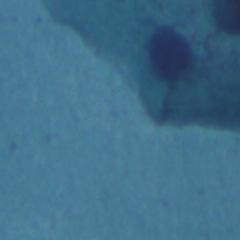

benign: 0.8444663882255554


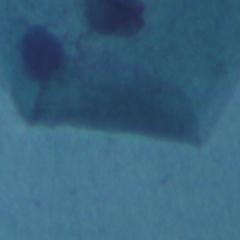

benign: 0.8619810938835144


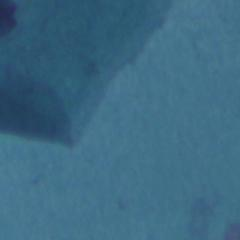

benign: 0.806486189365387


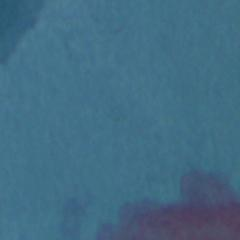

benign: 0.821450412273407


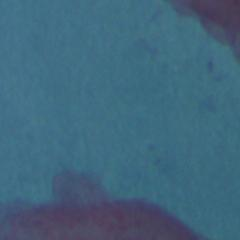

normal: 0.9995705485343933


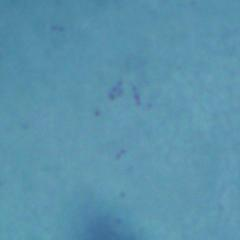

normal: 0.9997789263725281


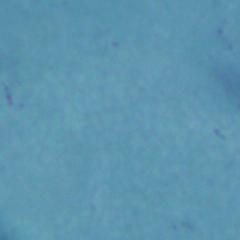

normal: 0.9997709393501282


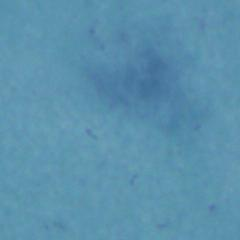

normal: 0.9997777342796326


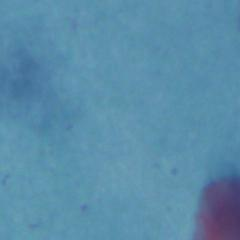

normal: 0.9997745156288147


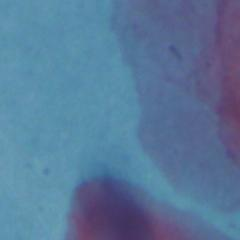

normal: 0.9424687623977661


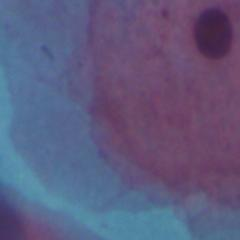

malignant: 0.9919384121894836


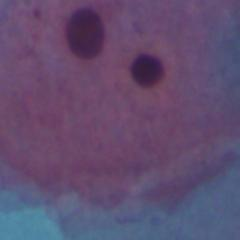

malignant: 0.8785327672958374


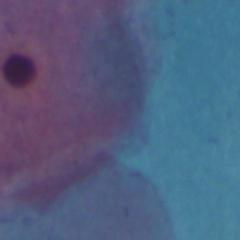

normal: 0.4661672115325928


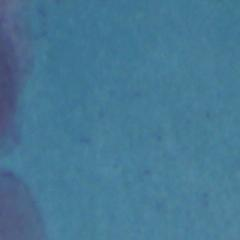

benign: 0.5068361759185791


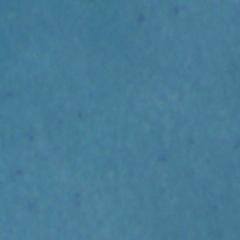

benign: 0.7936376333236694


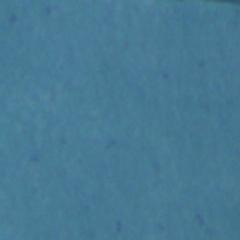

benign: 0.8789752125740051


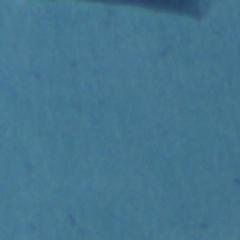

benign: 0.8807691335678101


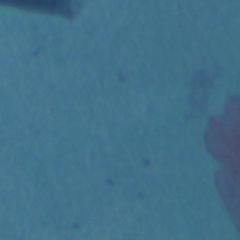

benign: 0.7462832927703857


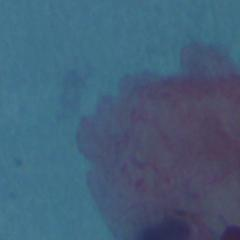

malignant: 0.5007669925689697


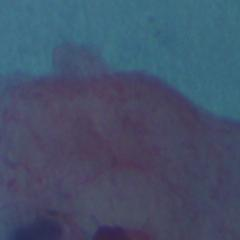

normal: 0.9997182488441467


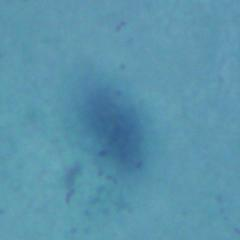

normal: 0.999862551689148


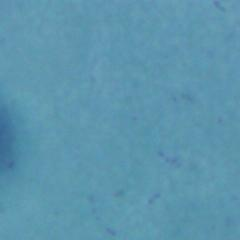

normal: 0.9998624324798584


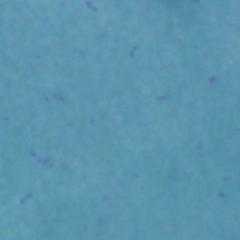

normal: 0.9998540878295898


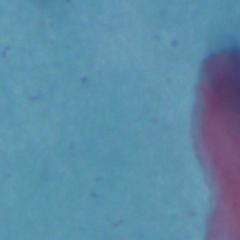

normal: 0.9893171191215515


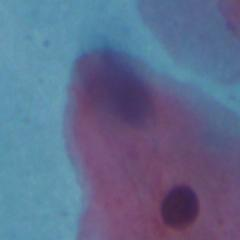

normal: 0.9858208894729614


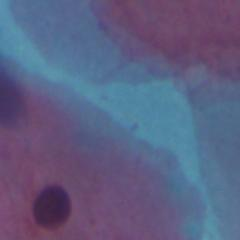

normal: 0.976226270198822


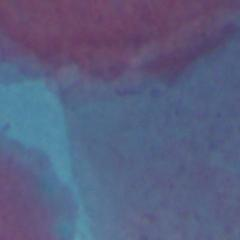

normal: 0.9466772079467773


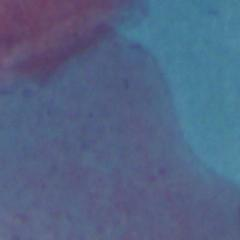

normal: 0.980440080165863


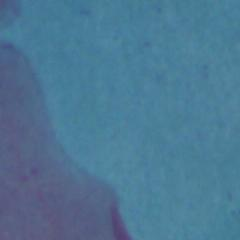

normal: 0.5924368500709534


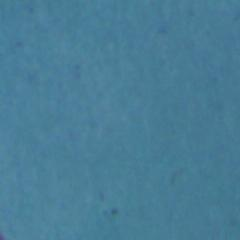

benign: 0.8859723806381226


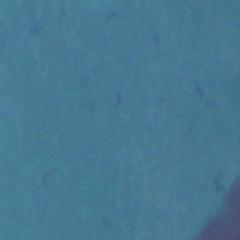

benign: 0.8606601357460022


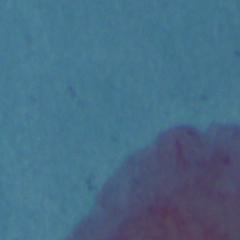

benign: 0.765602707862854


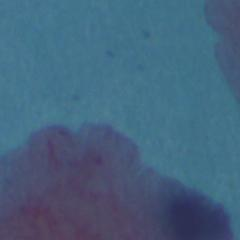

benign: 0.7886563539505005


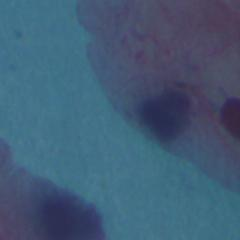

benign: 0.8102811574935913


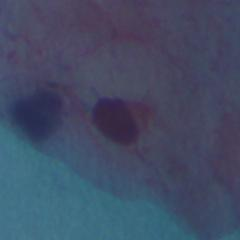

normal: 0.9997723698616028


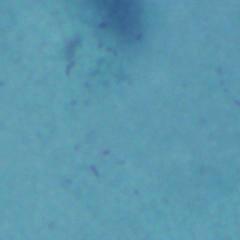

normal: 0.999861478805542


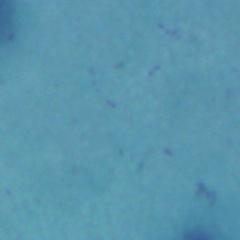

normal: 0.9998716115951538


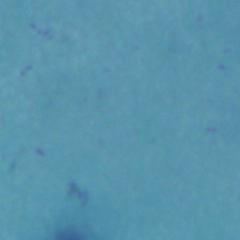

normal: 0.9996625185012817


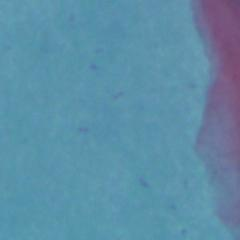

normal: 0.9968973398208618


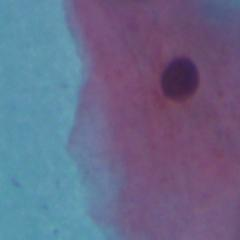

normal: 0.7864631414413452


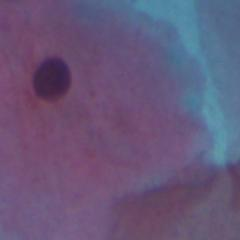

normal: 0.9358484745025635


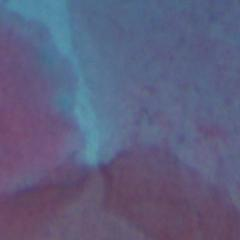

normal: 0.9808374047279358


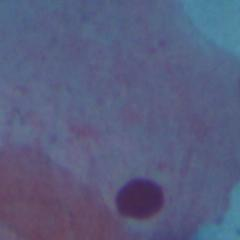

normal: 0.9783021211624146


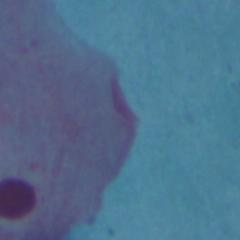

normal: 0.6895461082458496


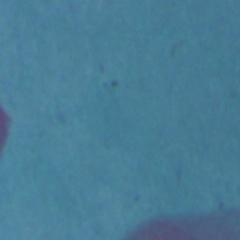

benign: 0.6404885649681091


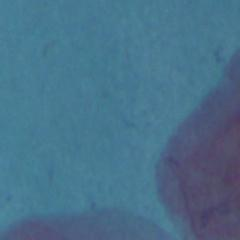

benign: 0.5251613855361938


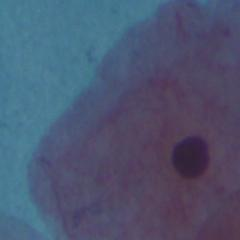

benign: 0.5236994028091431


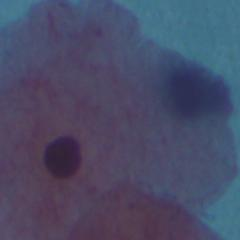

benign: 0.838528573513031


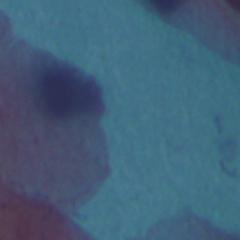

benign: 0.8082552552223206


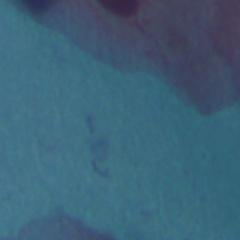

In [59]:

input_size = 224
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        normalize = transforms.Compose([
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # print image 
        
        # resize tensor to model input size
        x = F.interpolate(patches[0][i][j], size=224) 
        im = normalize(x)
        out = model(im.unsqueeze(0)).squeeze()
        # get the probability and category of top5 prediction
        prob, categories = out.topk(3)
        # convert the probability to softmax
        sm = torch.nn.Softmax()
        probabilities = sm(prob) 
        
        print(class_name[int(categories[0])] + ": " + str(float(probabilities[0])))
        inp = transp(patches[0][i][j])
        inp = np.array(inp)
        showarray(inp)